# Prerequisites

- SSS pdf
- Polynomial intuition

# Theory

- [Wikipedia](https://en.wikipedia.org/wiki/Shamir%27s_Secret_Sharing)
- [Video explanation](https://www.youtube.com/watch?v=kkMps3X_tEE)

## Polynomials

### Lagrange interpolation
- [Wikipedia entry](https://en.wikipedia.org/wiki/Lagrange_polynomial)

We know that given $d+1$ points we can use polynomial interpolation to generate a polynomial of degree $d$

**Lagrange polynomial**  
Given $(x_0, y_0),...,(x_k,y_k)$ the interpolation polynomial is the linear combination
$$L(x) = \sum^k_{j=0} y_jl_j(x)$$

of the lagrange basis polynomials
$$l_j(x) = \prod_{0<m<k \ ; \ m\neq j} \dfrac {x - x_m} {x_j - x_m}$$

$l_j(x) = 1 \text{ if } i == j \text{ else } 0$

Notice that 
- $L(x_i) = y_i$
- $L$ is unique


*Intuition*: 2 polynomials define a line, 3 define a parabola, etc

**Note**:
- This extends to **fields** too (Like $\mathbb{Z}_p$ when $p$ is prime)

### Polynomials mod $p$

Let 
- $p$ be a prime
- $\{(x_1,y_1),...,(x_{d+1},y_{d+1})\} ⊆(\mathbb{Z}_p)^2$  be a set of points whose $x_i$ values are all distinct. 

> Then there is a unique degree $d$ polynomial $f$ with coefficients from $\mathbb{Z}_p$ that satisfies  $y_i≡f(x_i) \bmod p \ \forall \ i$.

Polynomial over a finite field

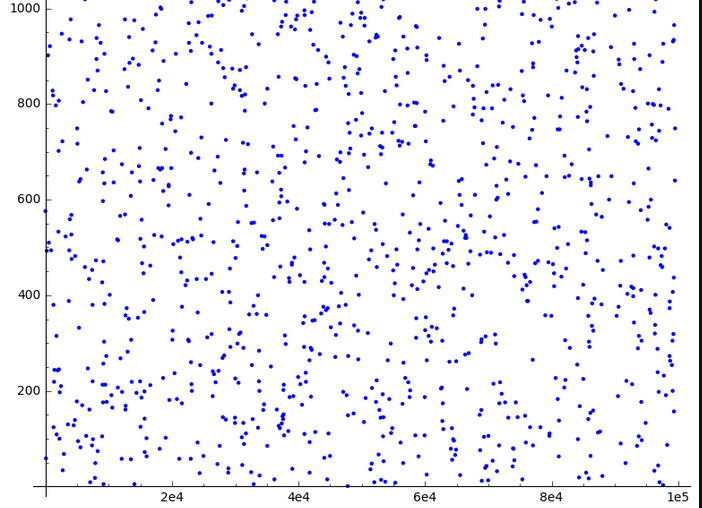
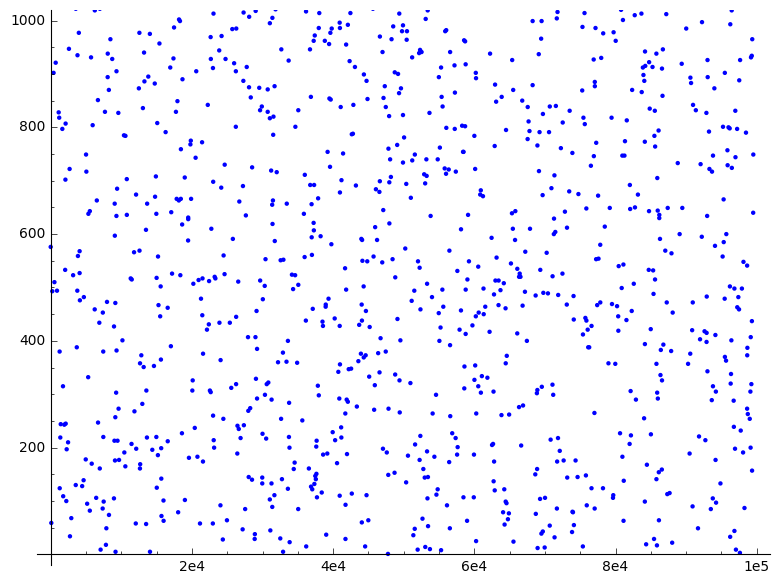

### Computationally efficient approach

Unused constants are calculated -> we can do better

$$L(0) = \sum_{j=0}^{k-1}f(x_j) \prod_{m=0 \ ; \ m\neq j}^{k-1} \dfrac {x_m} {x_m - x_j}$$

**Security problem**
- Eve gains information about the secret with every point she finds
- See wikipedia example

## SSSS

Let
- $m \in \mathbb{Z}_p$ be a secret
- $t$ be the threshold we want
- $n$ be the number of involved parties

Choose $t-1$ degree polynomial $f$ that satisfies $f(0) \equiv m \bmod p$ with coefficients uniformly distributed in $\mathbb{Z}_p$

**Share**
- Choose $(x_i, f(x_i) \bmod  p)$ points as shares

**Reconstruct**
- Using the interpolation theorem we can reconstruct the polynomial using $t$ shares

### Security
> We want to prove that $\forall m \in \mathbb{Z}_p$ any $t-1$ shares are uniformly and independently distributed over $\mathbb{Z}_p$


- Let $m$ and $(x_1, x_{t-1})$ be fixed
- The map that sends the $t-1$ coefficients of the polynomial to the $t-1$ $y$s is one to one
	- If the map is not one to one then we have two distinct polynomials that agree at the same interpolated points which contradicts the uniqueness of polynomial interpolation
- Since the coefficients are uniformly chosen then the $y$s must be uniformly distributed too => indistinguishable from random




# Code

## Wikipedia implementation

In [12]:
import matplotlib.pyplot as plt
from Crypto.Util.number import isPrime

In [1]:
"""
The following Python implementation of Shamir's Secret Sharing is
released into the Public Domain under the terms of CC0 and OWFa:
https://creativecommons.org/publicdomain/zero/1.0/
http://www.openwebfoundation.org/legal/the-owf-1-0-agreements/owfa-1-0

See the bottom few lines for usage. Tested on Python 2 and 3.
"""

from __future__ import division, print_function

import functools
import random

# 12th Mersenne Prime
# (for this application we want a known prime number as close as
# possible to our security level; e.g.  desired security level of 128
# bits -- too large and all the ciphertext is large; too small and
# security is compromised)
_PRIME = 2**127 - 1
# 13th Mersenne Prime is 2**521 - 1

_RINT = functools.partial(random.SystemRandom().randint, 0)


def _eval_at(poly, x, prime):
    """Evaluates polynomial (coefficient tuple) at x, used to generate a
    shamir pool in make_random_shares below.
    """
    accum = 0
    for coeff in reversed(poly):
        accum *= x
        accum += coeff
        accum %= prime
    return accum


def make_random_shares(minimum, shares, prime=_PRIME):
    """
    Generates a random shamir pool, returns the secret and the share
    points.
    """
    if minimum > shares:
        raise ValueError("Pool secret would be irrecoverable.")
    poly = [_RINT(prime - 1) for i in range(minimum)]
    points = [(i, _eval_at(poly, i, prime)) for i in range(1, shares + 1)]
    return poly[0], points


def _extended_gcd(a, b):
    """
    Division in integers modulus p means finding the inverse of the
    denominator modulo p and then multiplying the numerator by this
    inverse (Note: inverse of A is B such that A*B % p == 1) this can
    be computed via extended Euclidean algorithm
    http://en.wikipedia.org/wiki/Modular_multiplicative_inverse#Computation
    """
    x = 0
    last_x = 1
    y = 1
    last_y = 0
    while b != 0:
        quot = a // b
        a, b = b, a % b
        x, last_x = last_x - quot * x, x
        y, last_y = last_y - quot * y, y
    return last_x, last_y


def _divmod(num, den, p):
    """Compute num / den modulo prime p

    To explain what this means, the return value will be such that
    the following is true: den * _divmod(num, den, p) % p == num
    """
    inv, _ = _extended_gcd(den, p)
    return num * inv


def _lagrange_interpolate(x, x_s, y_s, p):
    """
    Find the y-value for the given x, given n (x, y) points;
    k points will define a polynomial of up to kth order.
    """
    k = len(x_s)
    assert k == len(set(x_s)), "points must be distinct"

    def PI(vals):  # upper-case PI -- product of inputs
        accum = 1
        for v in vals:
            accum *= v
        return accum

    nums = []  # avoid inexact division
    dens = []
    for i in range(k):
        others = list(x_s)
        cur = others.pop(i)
        nums.append(PI(x - o for o in others))
        dens.append(PI(cur - o for o in others))
    den = PI(dens)
    num = sum([_divmod(nums[i] * den * y_s[i] % p, dens[i], p) for i in range(k)])
    return (_divmod(num, den, p) + p) % p


def recover_secret(shares, prime=_PRIME):
    """
    Recover the secret from share points
    (x, y points on the polynomial).
    """
    if len(shares) < 2:
        raise ValueError("need at least two shares")
    x_s, y_s = zip(*shares)
    return _lagrange_interpolate(0, x_s, y_s, prime)

In [15]:
poly = [1, 2, 3, 4]
prime = 127
xs = list(range(prime))
ys = [_eval_at(poly, x, prime) for x in xs]

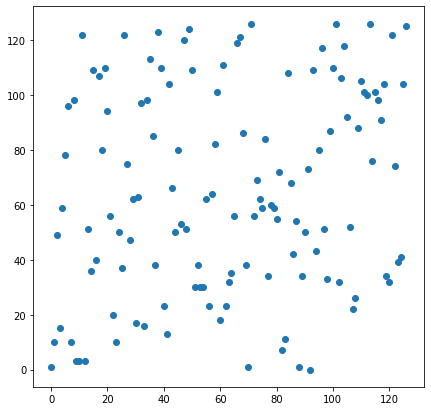

In [19]:
plt.figure(figsize = (7, 7))
plt.scatter(xs, ys)
plt.show()

In [20]:
secret, shares = make_random_shares(minimum=3, shares=6)
print(secret)
print(shares)

52314396035862513155819657665453925368
[(1, 27105476584054180470837109449966277333), (2, 36925420779536819195493422097587641913), (3, 81774228622310429329788595608318019108), (4, 161651900112375010873722629982157408918), (5, 106417251789261332095608221503221705616), (6, 86211467113438624727132673887395014929)]


In [21]:
print(recover_secret(shares[:3]))
print(recover_secret(shares[-3:]))

52314396035862513155819657665453925368
52314396035862513155819657665453925368


# Resources
- https://www.youtube.com/watch?v=iFY5SyY3IMQ - Another good watch
- https://www.youtube.com/watch?v=K54ildEW9-Q&t